In [172]:
### Multi-layer perceptrons for classification and regression problems.

import os
os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
import scipy as sp
import tensorflow as tf
import random as rn
from keras.models import Sequential

import keras
from keras import backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras import metrics, regularizers, optimizers

from sklearn.metrics import *

import matplotlib.pyplot as plt
import matplotlib as mpl


# The size of the plots.
mpl.rcParams['figure.figsize'] = (5,5)


# To have the plots inside the notebook "inlin" should be True. 
# If "inlin" = False, then plots will pop out of the notebook
inlin = True # True/False
if inlin:
    %matplotlib inline
else:
    %matplotlib 


In [3]:


def pipline(inp_dim,
            n_nod,
            act_fun = 'relu',
            out_act_fun = 'sigmoid',
            opt_method = 'Adam',
            cost_fun = 'binary_crossentropy',
            lr_rate = 0.01, 
            lambd = 0.0, 
            num_out = None):
    
    lays = [inp_dim] + n_nod
    
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input')
    
    X = main_input
    for nod in n_nod:
        X = Dense(nod, 
                  activation = act_fun,
                  kernel_regularizer=regularizers.l2(lambd))(X)
        
    output = Dense(num_out, activation = out_act_fun )(X)
    
    method = getattr(keras.optimizers, opt_method)
    
    model =  Model(inputs=[main_input], outputs=[output])
    model.compile(optimizer = method(lr = lr_rate),
                  loss = cost_fun)
                  #metrics=['accuracy', 'mse'])   
    
    return model



In [102]:
def syn1(N):
    """ data(samples, features)"""
    
    global seed
    
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)
  
    data[:N1,0] = 4 + np.random.normal(loc=.0, scale=1., size=(N1))
    data[N1:,0] = -4 + np.random.normal(loc=.0, scale=1., size=(N-N1))
    data[:,1] = 10*np.random.normal(loc=.0, scale=1., size=(N))
    
    
    data = data / data.std(axis=0)
    
    # Target
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    # Rotation
    theta = np.radians(30)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c,-s],[s,c]]) # rotation matrix
    data = np.dot(data,R) 
    
    return data,tar


def syn2(N):
    """ data(samples, features)"""
    
    global seed
     
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)

    # Positive samples
    data[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))
    # Negative samples 
    data[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))
    
    
    # Target
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))

    return data,tar


def syn3(N):
    """ data(samples, features)"""

    global seed
    
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(2*N/3)
    
    # disk
    teta_d = np.random.uniform(0, 2*np.pi, N1)
    inner, outer = 2, 5
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N1))
    data[:N1,0],data[:N1,1] = r2*np.cos(teta_d), r2*np.sin(teta_d)
        
    #circle
    teta_c = np.random.uniform(0, 2*np.pi, N-N1)
    inner, outer = 0, 3
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N-N1))
    data[N1:,0],data[N1:,1] = r2*np.cos(teta_c), r2*np.sin(teta_c)
    
    # Normalization
    #data = data - data.mean(axis=0)/data.std(axis=0)

    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    return data, tar


def regr1(N, v=0):
    """ data(samples, features)"""

    global seed

    data = np.empty(shape=(N,6), dtype = np.float32)  
    
    uni = lambda n : np.random.uniform(0,1,n)
    norm = lambda n : np.random.normal(0,1,n)
    noise =  lambda  n : np.random.normal(0,1,n)
    
    
    for i in range(4):
        data[:,i] = norm(N)
    for j in [4,5]:
        data[:,j] = uni(N)
    
    tar =   2*data[:,0] + data[:,1]* data[:,2]**2 + np.exp(data[:,3]) + \
            5*data[:,4]*data[:,5]  + 3*np.sin(2*np.pi*data[:,5])
    std_signal = np.std(tar)
    tar = tar + v * std_signal * noise(N)
        
    return data, tar

def spiral():
    tmp = np.loadtxt("spiral.dat")
    data, tar = tmp[:, :2], tmp[:, 2]

    return data, tar

def vowels():
    
    def pre_proc(file_name):
        block = []
        x = []
    
        with open(file_name) as file:
            for line in file:    
                if line.strip():
                    numbers = [float(n) for n in line.split()]
                    block.append(numbers)
                else:
                    x.append(block)
                    block = []
                
        ################################
        x = [np.asarray(ar) for ar in x]    
        return x

    x_train = pre_proc('ae.train')
    x_test = pre_proc('ae.test')

    
    ############## LABELS###########
    chunk1 = list(range(30,270, 30))
    y_train = []
    person = 0

    for i, block in enumerate(x_train):
        if i in chunk1:
            person += 1
        y_train.extend([person]*block.shape[0])
        
    chunk2 = [31,35,88,44,29,24,40,50,29]
    chunk2 = np.cumsum(chunk2)
    y_test = []
    person = 0
    for i, block in enumerate(x_test):
        if i in chunk2:
            person += 1
        y_test.extend([person]*block.shape[0])

    x_train = np.vstack(x_train)
    x_test = np.vstack(x_test)
    
    ## Split into train, validation and test
    num_classes = 9
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    from sklearn.model_selection import train_test_split

    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

    return x_train, y_train, x_val, y_val, x_test, y_test


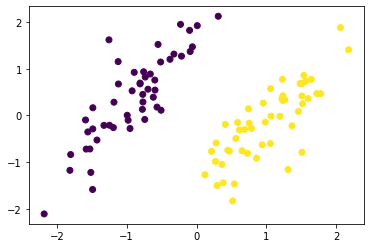

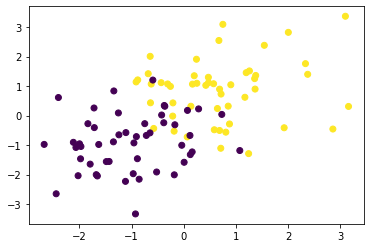

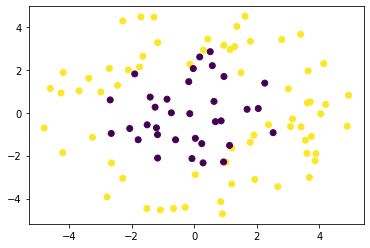

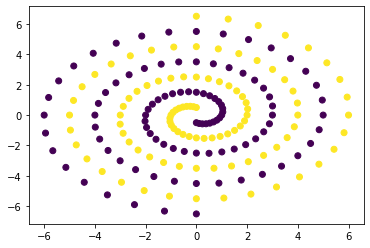

In [5]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

d,t = syn1(100)
plt.figure(1)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = syn2(100)
plt.figure(2)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = syn3(100)
plt.figure(3)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = spiral()
plt.figure(4)
plt.scatter(d[:,0],d[:,1], c=t)


### CellName: Statistics (#5)
### CellType: Needed
### Cell instruction: Present result for both classification and regression problems

This cell defines two functions that we are going to call using a trained model to calculate both error and performance measures. Run the cell by entering into the cell and press "CTRL Enter".

In [6]:
def stats_class(x = None, y = None, label = 'Training', modl = None):
    """
    input :  
             x = input
             y = output
             label = "Provided text string"
             modl = the model
             
    output : 
             sensitivity = fraction of correctly classified positive cases
             specificity = fraction of correctly classified negative cases
             accuracy = fraction of correctly classified cases
             loss = typically the cross-entropy error
    """
    
    def binary(y1):
        y1[y1>.5] = 1.
        y1[y1<= .5] = 0.        
        return y1

    y_pr = modl.predict(x, batch_size = x.shape[0], verbose=0).reshape(y.shape)
                
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [y==1, y_pr[y==1.] > 0.5, y==0, y_pr[y==0.]<= 0.5]]
    
    sens = tp / nof_p
    spec = tn / nof_n
    acc = (tp + tn) / (len(y))
    loss = modl.evaluate(x, y , batch_size =  x.shape[0], verbose=0)
                
    A = ['Accuracy', 'Sensitivity', 'Specificity', 'Loss']
    B = [acc, sens, spec, loss]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for r in zip(A,B):
         print(*r, sep = '   ')
    return print('\n','#'*50)

def stats_reg(d = None, d_pred = None, label = 'Training', estimat = None):
    
    A = ['MSE', 'CorrCoeff']
    
    pcorr = np.corrcoef(d, d_pred)[1,0]
    
    if label.lower() in ['training', 'trn', 'train']:
        mse = estimat.history['loss'][-1]
    else:
        mse = estimat.history['val_loss'][-1] 

    B = [mse, pcorr]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for r in zip(A,B):
         print(*r, sep = '   ')
    return print('\n','#'*50)



In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [8]:
def decision_b(X = None, Y1 = None ):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    Z[Z>.5] = 1
    Z[Z<= .5] = 0

    Y_pr = model.predict(X, batch_size = X.shape[0], verbose=0).reshape(Y1.shape)
  
    Y = np.copy(Y1)
    Y_pr[Y_pr>.5] = 1
    Y_pr[Y_pr<= .5] = 0
    Y[(Y!=Y_pr) & (Y==0)] = 2
    Y[(Y!=Y_pr) & (Y==1)] = 3
    
    
    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9) 
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker='+', c='k')
    plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], marker='o', c='k')
       
    plt.scatter(X[:, 0][Y==3], X[:, 1][Y==3], marker = '+', c='r')   
    plt.scatter(X[:, 0][Y==2], X[:, 1][Y==2], marker = 'o', c='r')
    
    
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.tight_layout()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________



2021-09-22 17:15:09.815502: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 17:15:09.815748: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.



 ########## STATISTICS for Training Data ########## 

Accuracy   1.0
Sensitivity   1.0
Specificity   1.0
Loss   0.0024236913304775953

 ##################################################


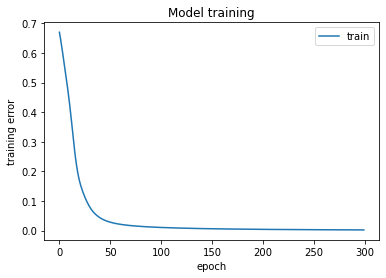

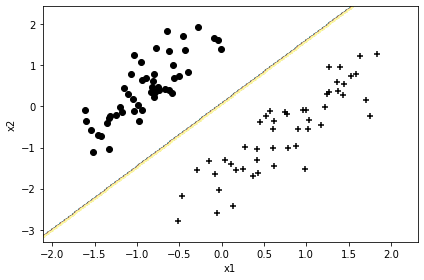

In [9]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None
    
# Generate training data
x_train, d_train = syn1(100)

# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [1],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.07,                    # learningrate
         'num_out' : 1 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipline(**INPUT)

# Print a summary of the model
model.summary()

# Train the model
estimator = model.fit(x_train, d_train,
                      epochs = 300,                    
                      batch_size = x_train.shape[0],                
                      verbose = 0)

# Call the stats function to print out statistics for the training
stats_class(x_train, d_train, 'Training', model)

# Some plotting
plt.plot(estimator.history['loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(['train'], loc=0)
plt.show()

# Show the decision boundary
decision_b(x_train, d_train)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________

 ########## STATISTICS for Training Data ########## 

Accuracy   0.8066666666666666
Sensitivity   0.85
Specificity   0.72
Loss   0.299185574054718

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.851
Sensitivity   0.8903903903903904
Specificity   0.7724550898203593
Loss   0.2992211878299713

 ########################

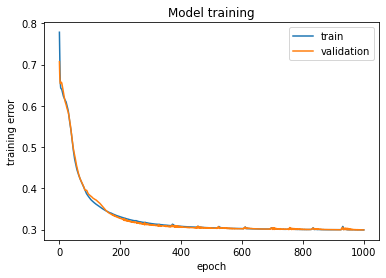

CPU times: user 12 s, sys: 995 ms, total: 13 s
Wall time: 8.62 s


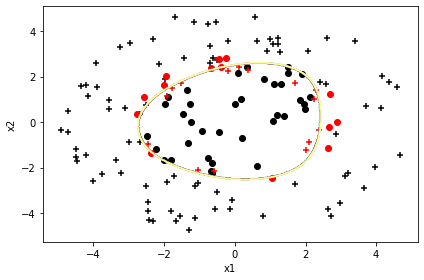

In [10]:

%%time
# seed = 0 means random, seed > 0 means fixed
seed = 3
np.random.seed(seed) if seed else None

# Generate training data
x_train, d_train = syn3(150)
x_val, d_val = syn3(1000)

# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [3],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.07 ,                    # learningrate
         'num_out' : 1 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipline(**INPUT)

# Print a summary of the model
model.summary()

# Train the model
estimator = model.fit(x_train, d_train,
                      epochs = 1000,      
                      validation_data=(x_val, d_val),
                      batch_size = x_train.shape[0],    # Batch size = all data (batch learning)
                      #batch_size=50,                   # Batch size for true SGD
                      verbose = 0)

# Call the stats function to print out statistics for classification problems
stats_class(x_train, d_train, 'Training', model)
stats_class(x_val, d_val, 'Validation', model)

# Plot the learning curves
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)
plt.show()

# Show the decision boundary for the training dataset
decision_b(x_train, d_train)

# If you uncomment this one you will see how the decsion boundary is with respect to the validation data
#decision_b(x_val, d_val)

train input size:  (250, 6) train target size:  (250,)
val   input size:  (250, 6) val   target size:  (250,)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                105       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

 ########## STATISTICS for Training Data ########## 

MSE   0.2978199601173401
CorrCoeff   0.8736490253013445

 ##################################################

 ########## STATISTICS for Validation Data ########## 

MSE   0.4395984411239624
CorrCoeff   0.7975073129634657

 ##

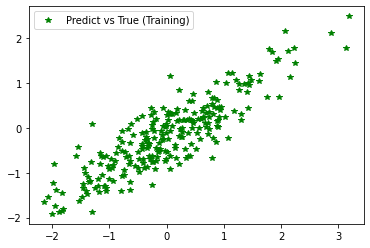

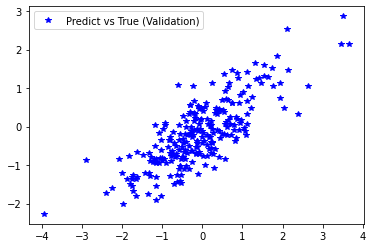

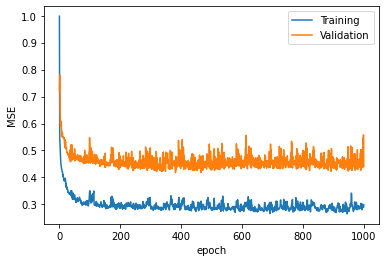

CPU times: user 18.4 s, sys: 1.95 s, total: 20.3 s
Wall time: 10.3 s


In [11]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 10
np.random.seed(seed) if seed else None

# Generate training and validation data
x_train, d_train = regr1(250, 0.4) # 250 data points with no noise
x_val, d_val = regr1(250, 0.4)

# Here we need to normalize the target values
norm_m = d_train.mean(axis=0)
norm_s = d_train.std(axis=0)
d_train = (d_train - norm_m) / norm_s

# We use the same normalization for the validation data.
d_val = (d_val - norm_m) / norm_s

print('train input size: ',x_train.shape, 'train target size: ',d_train.shape)
print('val   input size: ',x_val.shape, 'val   target size: ',d_val.shape)


# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [15],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'linear',           # output activation function
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'mse',                 # error function
         'lr_rate': 0.03,                   # learningrate
         'lambd' : 0.005,                    # L2
         'num_out' : 1 }   # if binary --> 1 |  regression--> num output | multi-class--> num of classes

# Get the model
model = pipline(**INPUT)

# Print a summary of the model
model.summary()

# Train the model
estimator = model.fit(x_train, 
                      d_train,
                      epochs = 1000,      # Number of epochs
                      validation_data=(x_val,d_val),
                      #batch_size = x_train.shape[0],   # Batch size = all data (batch learning)
                      batch_size=50,                    # Batch size for true SGD
                      verbose = 0)

# Call the stats function to print out statistics for classification problems
pred_trn = model.predict(x_train).reshape(d_train.shape)
pred_val = model.predict(x_val).reshape(d_val.shape)
stats_reg(d_train, pred_trn, 'Training', estimator)
stats_reg(d_val, pred_val, 'Validation', estimator)

# Scatter plots of predicted and true values
plt.figure()
plt.plot(d_train, pred_trn, 'g*', label='Predict vs True (Training)')
plt.legend()
plt.figure()
plt.plot(d_val, pred_val, 'b*', label='Predict vs True (Validation)')
plt.legend()
plt.show()

# Plot the learning curves
plt.figure()
plt.plot(estimator.history['loss'], label='Training')
plt.plot(estimator.history['val_loss'], label='Validation')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()


In [140]:
%%time
seed = 2
np.random.seed(seed) if seed else None

x_train, y_train, x_val, y_val, x_test, y_test = vowels()
num_classes = 9


norm_m = x_train.mean(axis=0)
norm_s = x_train.std(axis=0)+0.000001
x_train = (x_train - norm_m) / norm_s
x_test = (x_test - norm_m) / norm_s


print('train input size: ',x_train.shape, 'train target size: ',y_train.shape)
print('val   input size: ',x_val.shape, 'val   target size: ',y_val.shape)
print('test  input size: ',x_test.shape, 'test  target size: ',y_test.shape)


INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [3],                      
         'act_fun': 'sigmoid',                 
         'out_act_fun': 'sigmoid',          
         'opt_method': 'Adam',              
         'cost_fun': 'categorical_crossentropy',
         'lr_rate': 0.01 , 
         'lambd' : 0.005, 
         'num_out' : 9 }          
    

model_vowels = pipline(**INPUT)

model_vowels.summary()

model_vowels.fit(x_train, y_train,
                      epochs = 1000,      
                      validation_data=(x_val, y_val),
                      batch_size = 128,
                      verbose = 0)


train input size:  (4274, 12) train target size:  (4274, 9)
val   input size:  (2275, 12) val   target size:  (2275, 9)
test  input size:  (3412, 12) test  target size:  (3412, 9)
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 12)                0         
_________________________________________________________________
dense_179 (Dense)            (None, 3)                 39        
_________________________________________________________________
dense_180 (Dense)            (None, 9)                 36        
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________
Train on 4274 samples, validate on 2275 samples
Epoch 1/1000
4274/4274 [==============================] - 3s 751us/step - loss: 2.1882 - val_loss: 2.2133
Epoch 2/1000
4274/4274 [==============================] - 

Epoch 146/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.5485 - val_loss: 2.9081
Epoch 147/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5451 - val_loss: 2.8409
Epoch 148/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.5441 - val_loss: 2.8054
Epoch 149/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.5418 - val_loss: 2.8017
Epoch 150/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5449 - val_loss: 2.8319
Epoch 151/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5439 - val_loss: 2.8645
Epoch 152/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.5449 - val_loss: 2.9199
Epoch 153/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5409 - val_loss: 2.8321
Epoch 154/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.5402 - val_loss: 2.8380
Epoch 155/1000
4274/4274 [===========

4274/4274 [==============================] - 0s 42us/step - loss: 0.5042 - val_loss: 3.3819
Epoch 299/1000
4274/4274 [==============================] - 0s 41us/step - loss: 0.5035 - val_loss: 3.4234
Epoch 300/1000
4274/4274 [==============================] - 0s 37us/step - loss: 0.5016 - val_loss: 3.3578
Epoch 301/1000
4274/4274 [==============================] - 0s 37us/step - loss: 0.5025 - val_loss: 3.4266
Epoch 302/1000
4274/4274 [==============================] - 0s 37us/step - loss: 0.5028 - val_loss: 3.4528
Epoch 303/1000
4274/4274 [==============================] - 0s 37us/step - loss: 0.5033 - val_loss: 3.2945
Epoch 304/1000
4274/4274 [==============================] - 0s 34us/step - loss: 0.5016 - val_loss: 3.4381
Epoch 305/1000
4274/4274 [==============================] - 0s 32us/step - loss: 0.5029 - val_loss: 3.5168
Epoch 306/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.5055 - val_loss: 3.3647
Epoch 307/1000
4274/4274 [==========================

4274/4274 [==============================] - 0s 31us/step - loss: 0.4884 - val_loss: 4.0050
Epoch 451/1000
4274/4274 [==============================] - 0s 35us/step - loss: 0.4946 - val_loss: 4.0814
Epoch 452/1000
4274/4274 [==============================] - 0s 35us/step - loss: 0.4939 - val_loss: 3.8837
Epoch 453/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.4967 - val_loss: 3.9568
Epoch 454/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.4865 - val_loss: 4.0694
Epoch 455/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.4910 - val_loss: 3.9408
Epoch 456/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.4871 - val_loss: 4.0245
Epoch 457/1000
4274/4274 [==============================] - 0s 33us/step - loss: 0.4893 - val_loss: 4.0061
Epoch 458/1000
4274/4274 [==============================] - 0s 32us/step - loss: 0.4906 - val_loss: 4.0130
Epoch 459/1000
4274/4274 [==========================

4274/4274 [==============================] - 0s 33us/step - loss: 0.4992 - val_loss: 4.6619
Epoch 603/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.4972 - val_loss: 4.8617
Epoch 604/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.5007 - val_loss: 4.6287
Epoch 605/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.4955 - val_loss: 4.7066
Epoch 606/1000
4274/4274 [==============================] - 0s 33us/step - loss: 0.4973 - val_loss: 4.7050
Epoch 607/1000
4274/4274 [==============================] - 0s 35us/step - loss: 0.4932 - val_loss: 4.6546
Epoch 608/1000
4274/4274 [==============================] - 0s 31us/step - loss: 0.4990 - val_loss: 4.6831
Epoch 609/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.4890 - val_loss: 4.8042
Epoch 610/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.4972 - val_loss: 4.8880
Epoch 611/1000
4274/4274 [==========================

4274/4274 [==============================] - 0s 30us/step - loss: 0.5136 - val_loss: 5.5299
Epoch 755/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5176 - val_loss: 5.7356
Epoch 756/1000
4274/4274 [==============================] - 0s 29us/step - loss: 0.5190 - val_loss: 5.5229
Epoch 757/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5207 - val_loss: 5.8869
Epoch 758/1000
4274/4274 [==============================] - 0s 29us/step - loss: 0.5255 - val_loss: 5.4967
Epoch 759/1000
4274/4274 [==============================] - 0s 29us/step - loss: 0.5071 - val_loss: 5.7523
Epoch 760/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5291 - val_loss: 5.6091
Epoch 761/1000
4274/4274 [==============================] - 0s 29us/step - loss: 0.5297 - val_loss: 5.8533
Epoch 762/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5257 - val_loss: 5.6220
Epoch 763/1000
4274/4274 [==========================

4274/4274 [==============================] - 0s 30us/step - loss: 0.5491 - val_loss: 6.6044
Epoch 907/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5518 - val_loss: 6.3697
Epoch 908/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5490 - val_loss: 6.5351
Epoch 909/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5444 - val_loss: 6.6902
Epoch 910/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5511 - val_loss: 6.5533
Epoch 911/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5528 - val_loss: 6.6521
Epoch 912/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5506 - val_loss: 6.5242
Epoch 913/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5418 - val_loss: 6.6129
Epoch 914/1000
4274/4274 [==============================] - 0s 30us/step - loss: 0.5419 - val_loss: 6.6973
Epoch 915/1000
4274/4274 [==========================


 ########## Result for Test Data ########## 

log_loss:    0.4875887588283452
accuracy:    0.8349941383352872 

              precision    recall  f1-score   support

     class 1       0.92      0.88      0.90       303
     class 2       0.72      0.81      0.77       322
     class 3       0.91      0.85      0.88       708
     class 4       0.89      0.87      0.88       528
     class 5       0.72      0.68      0.70       247
     class 6       0.90      0.97      0.93       265
     class 7       0.92      0.95      0.93       400
     class 8       0.71      0.64      0.68       384
     class 9       0.69      0.82      0.75       255

    accuracy                           0.83      3412
   macro avg       0.82      0.83      0.82      3412
weighted avg       0.84      0.83      0.83      3412



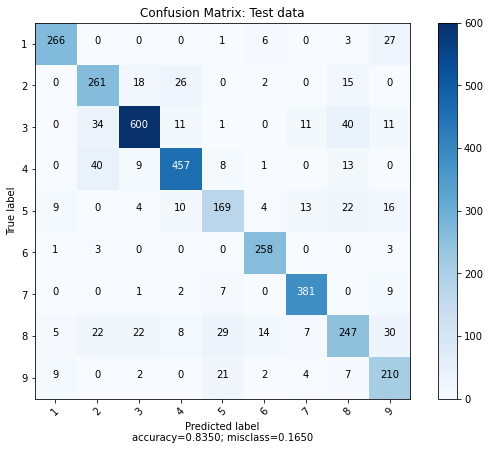

In [139]:
"""
This cell can be used to present the classification results. 
It assumes you trained model has the name 'model_vowels'. 
It shows the test data results, but it can be changed to show
the training/validation.
"""
print('\n','#'*10,'Result for {} Data'.format('Test'), '#'*10, '\n')

y_pred = model_vowels.predict(x_test, verbose=0 )
print('log_loss:   ', log_loss(y_test, y_pred, eps=1e-15))

y_true = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)
print('accuracy:   ',(y_pred==y_true).mean(), '\n')

target_names = ['class {}'.format(i+1) for i in range(9)]
print(classification_report(y_true, y_pred, target_names=target_names))

confuTst = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm           = confuTst, 
                      normalize    = False,
                      target_names = ['1', '2', '3', '4', '5', '6','7', '8','9'],
                      title        = "Confusion Matrix: Test data")



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 16)                48        
_________________________________________________________________
dense_271 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_272 (Dense)            (None, 16)                272       
_________________________________________________________________
dense_273 (Dense)            (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________

 ########## STATISTICS for Training Data ########## 

Accuracy   1.0
Sensitivity   1.0
Specificity   1.0
Loss   [1.8153806236043124e-09, 1.0]

 ##################################################


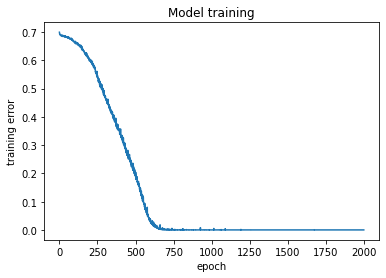

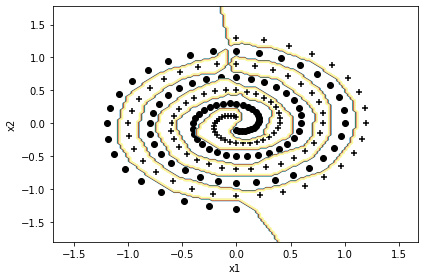

In [177]:
seed = 0
np.random.seed(seed) if seed else None

x_train, d_train = spiral()
x_train = x_train / 5


model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(2,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

method = getattr(keras.optimizers, 'RMSprop')
model.compile(loss='binary_crossentropy',optimizer = method(lr = 0.005),
              metrics=['accuracy'])
model.summary()

estimator = model.fit(x_train, d_train, batch_size=32, epochs=2000, verbose=0)


stats_class(x_train, d_train, 'Training', model)

plt.plot(estimator.history['loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')

decision_b(x_train, d_train)
plt.show()
